In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import collections
import itertools

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy as sp
import scipy.io as sio

/Users/z002krv/anaconda3/envs/TensorFlow_RB/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from six.moves import urllib

In [5]:
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(sp.__version__)

1.14.3
0.23.0
1.9.0
1.1.0


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
URL_TRAIN_PATH = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
URL_TEST_PATH = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

DOWNLOAD_TRAIN_FILE_NAME = "house_numbers_training.mat"
DOWNLOAD_TEST_FILE_NAME = "house_numbers_test.mat"

In [8]:
def load_housenumbers_data():
    if not os.path.exists(DOWNLOAD_TRAIN_FILE_NAME):
        filename,_ = urllib.request.urlretrieve(URL_TRAIN_PATH,DOWNLOAD_TRAIN_FILE_NAME)
    if not os.path.exists(DOWNLOAD_TEST_FILE_NAME):
        filename,_ = urllib.request.urlretrieve(URL_TEST_PATH,DOWNLOAD_TEST_FILE_NAME)

In [9]:
load_housenumbers_data()

In [10]:
train_mat = sio.loadmat(DOWNLOAD_TRAIN_FILE_NAME,squeeze_me=True)
test_mat = sio.loadmat(DOWNLOAD_TEST_FILE_NAME,squeeze_me=True)

In [11]:
type(train_mat)

dict

In [12]:
train_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [13]:
X_train = train_mat['X']
Y_train = train_mat['y']

X_test = test_mat['X']
Y_test = test_mat['y']

In [14]:
X_train.shape

(32, 32, 3, 73257)

In [15]:
X_train = np.transpose(X_train, (3,0,1,2))
X_test = np.transpose(X_test, (3,0,1,2))

In [54]:
X_train = X_train[:15000]
X_test = X_test[:1000]

In [55]:
Y_train = Y_train[:15000]
Y_test = Y_test[:1000]

In [56]:
def display_digit_image(digit):
    plt.imshow(digit,interpolation='nearest')

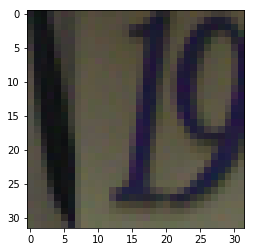

In [57]:
display_digit_image(X_train[0])

In [58]:
Y_train[0]

1

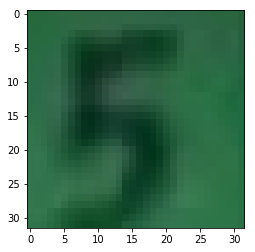

In [59]:
display_digit_image(X_test[0])

In [60]:
Y_test[0]

5

In [61]:
height = 32
weight = 32
channels = 3
n_inputs = height * weight

In [62]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

In [63]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

In [64]:
pool3_feature_maps = conv2_feature_maps

In [65]:
n_fullyconn1 = 64
n_outputs = 11

In [66]:
tf.reset_default_graph()

In [67]:
X = tf.placeholder(tf.float32, shape=[None,height,weight,channels], name="X")

In [68]:
y = tf.placeholder(tf.int32 , shape=[None] , name="y")

In [69]:
conv1 = tf.layers.conv2d(X , filters=conv1_feature_maps , kernel_size=conv1_kernel_size, strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name='conv1')

In [70]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [71]:
conv2 = tf.layers.conv2d(conv1 , filters=conv2_feature_maps , kernel_size=conv2_kernel_size, strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name='conv2')

In [72]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [73]:
pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

In [74]:
pool3.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(64)])

In [75]:
pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 8 * 8])

In [76]:
fullyCon1= tf.layers.dense(pool3_flat , n_fullyconn1, activation=tf.nn.relu, name='fc1')

In [77]:
logits = tf.layers.dense(fullyCon1, n_outputs, name="output")

In [78]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits , labels=y)

In [79]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
trainingOp = optimizer.minimize(loss)

In [80]:
correct = tf.nn.in_top_k(logits,y,1)

In [81]:
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [82]:
init = tf.global_variables_initializer()

In [83]:
current_batch = 0

def get_next_batch(batch_size):
    global current_batch
    
    start_index = (current_batch * batch_size) % len(Y_train)
    end_index = start_index + batch_size
    
    
    x_batch = X_train[start_index:end_index]
    y_batch = Y_train[start_index:end_index]
    
    current_batch = current_batch +1 
    
    return x_batch,y_batch

In [86]:
n_epochs = 20
batch_size = 100

In [87]:
with tf.Session() as session:
    init.run()
    
    num_samples = len(Y_train)
    
    for epoch in range(n_epochs):
        for iteration in range(num_samples//batch_size):
            X_batch , Y_batch = get_next_batch(batch_size)
            session.run(trainingOp,feed_dict={X:X_batch,y:Y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:Y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test,y:Y_test})
        print(epoch," Train Accuracy ",acc_train," Test Accuracy ",acc_test)

0  Train Accuracy  0.34  Test Accuracy  0.351
1  Train Accuracy  0.54  Test Accuracy  0.526
2  Train Accuracy  0.64  Test Accuracy  0.596
3  Train Accuracy  0.7  Test Accuracy  0.629
4  Train Accuracy  0.76  Test Accuracy  0.643
5  Train Accuracy  0.77  Test Accuracy  0.657
6  Train Accuracy  0.77  Test Accuracy  0.671
7  Train Accuracy  0.84  Test Accuracy  0.678
8  Train Accuracy  0.8  Test Accuracy  0.691
9  Train Accuracy  0.85  Test Accuracy  0.697
10  Train Accuracy  0.86  Test Accuracy  0.687
11  Train Accuracy  0.86  Test Accuracy  0.71
12  Train Accuracy  0.88  Test Accuracy  0.68
13  Train Accuracy  0.9  Test Accuracy  0.69
14  Train Accuracy  0.92  Test Accuracy  0.67
15  Train Accuracy  0.91  Test Accuracy  0.694
16  Train Accuracy  0.92  Test Accuracy  0.698
17  Train Accuracy  0.88  Test Accuracy  0.672
18  Train Accuracy  0.91  Test Accuracy  0.688
19  Train Accuracy  0.95  Test Accuracy  0.71
